In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adilguptagwl","key":"8d9b84d8f53905aa1d70492366b4f10f"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           7186        244  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           2463        103  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          17246        499  1.0              
sameepvani/nasa-nearest-earth-obje

In [3]:
!kaggle datasets download -d brycecf/give-me-some-credit-dataset

  0% 0.00/5.16M [00:00<?, ?B/s]
100% 5.16M/5.16M [00:00<00:00, 65.0MB/s]


In [4]:
!unzip give-me-some-credit-dataset.zip

Archive:  give-me-some-credit-dataset.zip
  inflating: Data Dictionary.xls     
  inflating: cs-test.csv             
  inflating: cs-training.csv         
  inflating: sampleEntry.csv         


In [23]:
#read data
import pandas as pd
import numpy as np
df = pd.read_csv('cs-training.csv')
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [24]:
cols_missing = [col for col in df.columns if df[col].isnull().any()]
for col in df.columns:
    df[col] = df[col].astype(float)
cols_without_missing =  [col for col in df.columns if col not in cols_missing]
cols_without_missing = cols_without_missing[2:]

In [25]:
X = df.drop(['Unnamed: 0','SeriousDlqin2yrs'],axis =1)
y = df['SeriousDlqin2yrs']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

In [28]:
#baseline model
model1= DecisionTreeClassifier(max_depth=7, min_samples_leaf=25, min_samples_split = 4, random_state=0)
model = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [29]:
#cv score calculator
def score(pipe, X,y):
    scoring = ['precision','recall','f1','roc_auc']
    r = cross_validate(pipe,X,y,cv=cv,scoring = scoring,n_jobs = -1)
    precision = r['test_precision'].mean()
    recall = r['test_recall'].mean()
    F1 = r['test_f1'].mean()
    AUC = r['test_roc_auc'].mean()
    return [precision,recall,F1,AUC]

In [30]:
#Base line score
BaseLineScore = score(model, X.drop(cols_missing,axis=1),y )
BaseLineScore

[0.5277049472266864,
 0.038100063898081314,
 0.07077432309321584,
 0.6903897487301223]

In [31]:
# handling missing values
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print(X.isnull().sum())

monthly_inc_trans = SimpleImputer(strategy = 'median')
dependent_trans = SimpleImputer(strategy = 'most_frequent')

handle_missing = ColumnTransformer([('monthly_inc',monthly_inc_trans,['MonthlyIncome']),('dependent',dependent_trans,['NumberOfDependents']),('same',monthly_inc_trans,cols_without_missing)])

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [32]:
#Remove skew and scaling
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

log_columns = X.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
print(log_columns)

log_trans = FunctionTransformer(np.log1p)
ss_trans = StandardScaler()

MonthlyIncome                           114.040318
RevolvingUtilizationOfUnsecuredLines     97.631574
DebtRatio                                95.157793
NumberOfTime60-89DaysPastDueNotWorse     23.331743
NumberOfTimes90DaysLate                  23.087345
NumberOfTime30-59DaysPastDueNotWorse     22.597108
NumberRealEstateLoansOrLines              3.482484
NumberOfDependents                        1.588242
NumberOfOpenCreditLinesAndLoans           1.215314
dtype: float64


In [33]:
#handling class imbalance
from imblearn.pipeline import Pipeline as ibPipeline
from imblearn.combine import SMOTEENN

smote = SMOTEENN(random_state  = 1)

In [34]:
#score after pre pprocessing
my_pipe =  ibPipeline([('handle_missing',handle_missing),('smote',smote),('log1p', log_trans),('ss', StandardScaler()),('model',model)])
score(my_pipe,X,y)

[0.21757733492242703,
 0.7352900898302599,
 0.3357818827337321,
 0.8536153103186214]

In [35]:
#final preprocessing pipeline
pre_process = ibPipeline([('handle_missing',handle_missing),('smote',smote),('log1p', log_trans),('ss', StandardScaler())])

In [36]:
X_m = handle_missing.fit_transform(X)
X_s, y_s = smote.fit_resample(X_m,y)
pre_processed_X , y_new = Pipeline([('log1p', log_trans),('ss', StandardScaler())]).fit_transform(X_s),y_s
pre_processed_X,y_new = pd.DataFrame(pre_processed_X),pd.DataFrame(y_new)
pre_processed_X.columns = X.columns
pre_processed_X

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,-0.314063,-0.894692,-0.490833,-1.523395,-0.623557,-0.549321,-0.353805,-0.448454,-1.107202,-0.376602
1,2.633981,-0.894692,0.673929,0.120530,0.505018,-0.553735,0.097220,-0.448454,0.297568,-0.376602
2,-0.255442,0.449942,-0.535928,1.514890,-0.623557,-0.433402,-0.989489,-0.448454,0.297568,-0.376602
3,-0.255442,-0.894692,0.450648,-0.646842,-0.623557,-0.485876,0.281878,-0.448454,-1.107202,-0.376602
4,1.649778,1.236503,-0.589384,0.630933,-0.623557,-0.370007,0.447062,-0.448454,2.154574,-0.376602
...,...,...,...,...,...,...,...,...,...,...
216577,-0.590644,0.660001,-0.657878,0.462565,0.627993,-0.108153,0.650510,-0.448454,1.621238,-0.376602
216578,0.176603,-0.894692,0.730596,-0.977714,1.047819,2.073082,-0.513972,0.573175,-1.107202,-0.376602
216579,-1.532834,0.449942,0.727467,-1.523395,-0.623557,-0.521666,-1.100753,-0.448454,-1.107202,-0.376602
216580,-0.344687,-0.699876,0.717678,-0.683365,0.505018,-0.498432,-0.989489,-0.272461,-1.107202,-0.376602


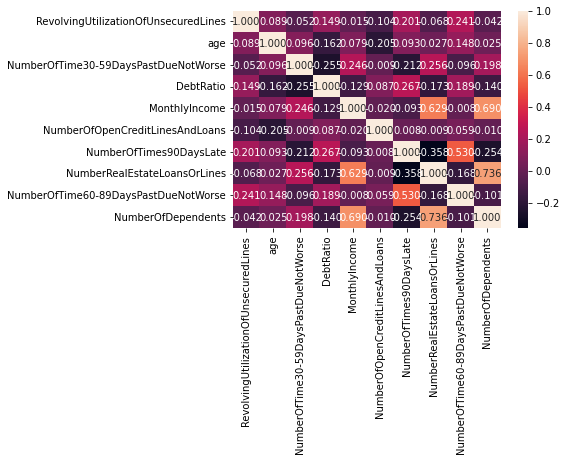

In [37]:
#EDA
#co relation matrix
import seaborn as sns

sns.heatmap(pre_processed_X.corr(), annot=True, fmt='.3f')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


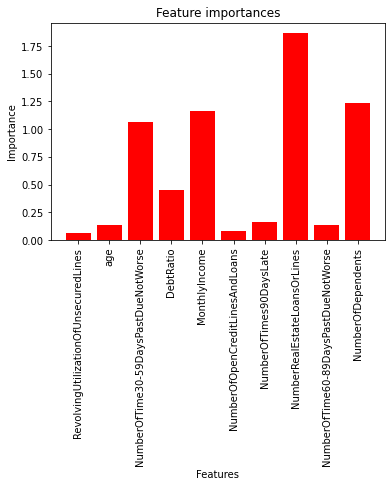

In [38]:
#feature importance
import matplotlib.pyplot as plt

model.fit(pre_processed_X,y_new)
name = pre_processed_X.columns
values = abs(model.coef_).flatten()

plt.bar(name, values, color ='r')
plt.xticks(name, name, rotation='vertical')
plt.title("Feature importances") 
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [39]:
#feature engineering
def feature_engineering(X):
    eng_X = X.copy()
    eng_X['Weighted_Sum_PastDue'] = 2 * eng_X['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * eng_X['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * eng_X['NumberOfTimes90DaysLate']

    eng_X['90days_out_of_TotalPastDue'] = eng_X['NumberOfTimes90DaysLate'] / (eng_X['Weighted_Sum_PastDue'])
    eng_X.loc[eng_X['Weighted_Sum_PastDue']==0, '90days_out_of_TotalPastDue'] = 0

    eng_X['RevolvingUtilization_per_age'] = eng_X['RevolvingUtilizationOfUnsecuredLines'] / (eng_X['age']+1)
    return eng_X

eng_X = feature_engineering(X)

In [40]:
#building pre processing line that can handle new features
cols_without_missing_after = cols_without_missing + ['Weighted_Sum_PastDue','90days_out_of_TotalPastDue','RevolvingUtilization_per_age']
handle_missing_new = ColumnTransformer([('monthly_inc',monthly_inc_trans,['MonthlyIncome']),('dependent',dependent_trans,['NumberOfDependents']),('same',monthly_inc_trans,cols_without_missing_after)])

pre_process_new = ibPipeline([('handle_missing',handle_missing_new),('smote',smote),('log1p', log_trans),('ss', StandardScaler())])

In [57]:
#score after feature engineering
my_pipe =  ibPipeline([('handle_missing',handle_missing_new),('smote',smote),('log1p', log_trans),('ss', StandardScaler()),('model', model)])
score(my_pipe,eng_X,y)

[0.3602567814025318,
 0.5050874807000445,
 0.4203196265855921,
 0.8443778286146157]

In [64]:
cv_new = StratifiedKFold(n_splits = 3, shuffle=True, random_state=0)
def score_new(pipe, X,y):
    r = cross_validate(pipe,X,y,cv=cv_new,scoring = 'f1',n_jobs = -1)
    return r['test_score'].mean()

In [65]:
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

In [66]:
CNN = CondensedNearestNeighbour()
ENN = EditedNearestNeighbours()
RENN = RepeatedEditedNearestNeighbours()
AKNN = AllKNN()
IHT = InstanceHardnessThreshold()
NM = NearMiss()
NCR = NeighbourhoodCleaningRule()
OSS = OneSidedSelection()
RUS = RandomUnderSampler()
TL = TomekLinks()

In [68]:
#f1 score still not good so we will try different under sampling and oversampling techniques
model = GaussianNB()
samples = [NCR,OSS,RUS,TL,NM,ENN,RENN,AKNN]
scores =[]
for sample in samples:
    pipe = ibPipeline([('handle_missing',handle_missing_new),('smple',sample),('log1p', log_trans),('ss', StandardScaler()),('model', model)])
    t = score_new(pipe, eng_X, y)
    print(t)
    scores.append(t)

0.41117335306199165
0.4227129894037125
0.4144166352931462
0.4227129894037125
0.2147988423133579
0.41346814984820823
0.4099730050322985
0.41163231904547887


In [73]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [75]:
S = SMOTE()
SN = SMOTEN()
A = ADASYN()
B = BorderlineSMOTE()
K = KMeansSMOTE()
SS = SVMSMOTE()
SEN = SMOTEENN()
ST = SMOTETomek()

In [77]:
model = GaussianNB()
samples = [S,SN,A,B,SEN,ST]
scores =[]
for sample in samples:
    pipe = ibPipeline([('handle_missing',handle_missing_new),('smple',sample),('log1p', log_trans),('ss', StandardScaler()),('model', model)])
    t = score_new(pipe, eng_X, y)
    print(t)
    scores.append(t)

0.4089636517576965


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.38886404653330375
0.40559643914416726
0.41052519047881947
0.40459241249984057
0.40811309879563096


In [79]:
# hyper parameter optimization using GScv
from sklearn.model_selection import GridSearchCV

In [102]:
resample = BorderlineSMOTE()

In [98]:
#logistic regression
LR = LogisticRegression() 
pipe = ibPipeline([('handle_missing',handle_missing_new),('resample',resample),('log1p', log_trans),('ss', StandardScaler()),('LR',LR)])

param_grid = {'LR__C': [3]}

search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs = -1,scoring = 'f1')

search.fit(eng_X,y)
search.best_params_

{'LR__C': 3}

In [100]:
#Gaussian NB
GNB = GaussianNB() 
pipe = ibPipeline([('handle_missing',handle_missing_new),('resample',resample),('log1p', log_trans),('ss', StandardScaler()),('GNB',GNB)])

param_grid = {'GNB__var_smoothing': np.logspace(0,-9, num=5)}

search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs = -1,scoring = 'f1')

search.fit(eng_X,y)
search.best_params_

{'GNB__var_smoothing': 1.0}

In [103]:
#Random Forest
RF = RandomForestClassifier()
pipe = ibPipeline([('handle_missing',handle_missing_new),('resample',resample),('log1p', log_trans),('ss', StandardScaler()),('RF',RF)])

param_grid = {'RF__max_depth' : [8],'RF__criterion' :['entropy'],'RF__max_features': ['log2']}

search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs = -1,scoring = 'f1')

search.fit(eng_X,y)
search.best_params_

{'RF__criterion': 'entropy', 'RF__max_depth': 8, 'RF__max_features': 'log2'}

In [123]:
#XGBoost
XGB = XGBClassifier()
pipe = ibPipeline([('handle_missing',handle_missing_new),('resample',resample),('log1p', log_trans),('ss', StandardScaler()),('XGB',XGB)])

param_grid = {'XGB__max_depth':[3],
              'XGB__eta':[0.7],
              'XGB__gamma': [1.1]}

search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs = -1,scoring = 'f1')

search.fit(eng_X,y)
search.best_params_

{'XGB__eta': 0.7, 'XGB__gamma': 1.1, 'XGB__max_depth': 3}

In [124]:
lr = LogisticRegression(C = 3)
gnb = GaussianNB(var_smoothing = 1)
rf = RandomForestClassifier(n_estimators = 100, max_features= 'log2', max_depth=3,criterion = 'entropy' )
xgb = XGBClassifier(eta = 0.7, gamma = 1.1, max_depth = 3)

In [125]:
models = [lr, gnb, rf, xgb]
scores =[]
for model in models:
    pipe = ibPipeline([('handle_missing',handle_missing_new),('resample',resample),('log1p', log_trans),('ss', StandardScaler()),('model', model)])
    scores.append(score(pipe, eng_X, y))

In [126]:
Final_results = pd.DataFrame({'LR':scores[0],'GNB':scores[1],'RF':scores[2],'XGB':scores[3]},index = ['precision','recall','F1','ROC AUC'])
Final_results

,LR,GNB,RF,XGB
precision,0.251437,0.375667,0.270533,0.443177
recall,0.670159,0.481150,0.633653,0.392678
F1,0.365647,0.421868,0.379149,0.416376
ROC AUC,0.854308,0.835796,0.848157,0.855260


In [127]:
import pickle
Baseline_results = pickle.load(open("BaselineResults",'rb'))
Baseline_results.index = ['precision','recall','F1','ROC AUC']
Baseline_results

,LR,GNB,RF,XGB
precision,0.527705,0.385897,0.524499,0.597193
recall,0.038100,0.024237,0.193996,0.186217
F1,0.070774,0.045575,0.283196,0.283789
ROC AUC,0.690390,0.712741,0.831798,0.863633


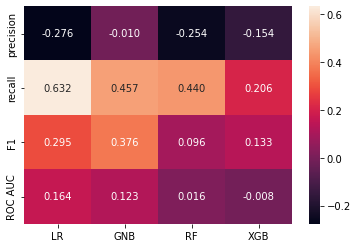

In [129]:
#improvement in results
improvement = Final_results - Baseline_results
sns.heatmap(improvement, annot=True, fmt='.3f')